# Étude du client 1

In [1]:
#import des librairies
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from joblib import dump


import sys
sys.path.append("../../scripts/")

# librairies perso
from import_data import import_data, import_data_complete
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure
from metrics import export_mesure, permutation_feature_importance

In [2]:
np.random.seed(42)

In [3]:
data = import_data_complete(path = "../../")

In [4]:
# on sélectionne le bon client : 
client = 1
data = data.groupby("id_client").get_group(client)
data = data.reset_index()
data = data.drop(["index", "id_client", "prediction"], axis = 1 )

In [5]:
# création d'un dataFrame où on stocke les résulats
results = pd.DataFrame(columns = ["MSE", "MAE", "R2", "crossVal"])
def concat_results(name, result): 
    df = pd.DataFrame(result, columns = [name], index = results.columns).T
    return pd.concat([results, df])

# Traitement des données

## On enlève les NaN

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   horodate                761 non-null    datetime64[ns]
 1   real_consumption        761 non-null    float64       
 2   forecasted_consumption  761 non-null    float64       
 3   CAC                     761 non-null    float64       
 4   AEX                     761 non-null    float64       
 5   BFX                     761 non-null    float64       
 6   STOXX                   761 non-null    float64       
 7   Airliquide              761 non-null    float64       
 8   gasNat                  761 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 53.6 KB


In [7]:
data.dropna(axis=1, inplace=True)

## On enlève les zéros en trop 

In [8]:
non_zero = np.max(np.where(data["real_consumption"] != 0))
data = data.iloc[:non_zero, :]
data.to_csv(f"../../output/client{client}/client{client}.csv")
data

,horodate,real_consumption,forecasted_consumption,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,2021-01-01,8396.00,8400.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,2021-01-02,8395.00,8400.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,2021-01-03,8396.00,8400.0,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,2021-01-04,8397.00,8400.0,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,2021-01-05,8395.73,8400.0,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...
742,2023-01-13,8393.57,8400.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
743,2023-01-14,8393.87,8400.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
744,2023-01-15,8393.82,8400.0,6989.589844,744.989990,3915.429932,4129.109863,143.559998,3.677
745,2023-01-16,8397.28,8400.0,7036.479980,748.940002,3944.040039,4155.740234,143.339996,3.677


# Visualisation des données

## Consommation prédite vs consommation réelle

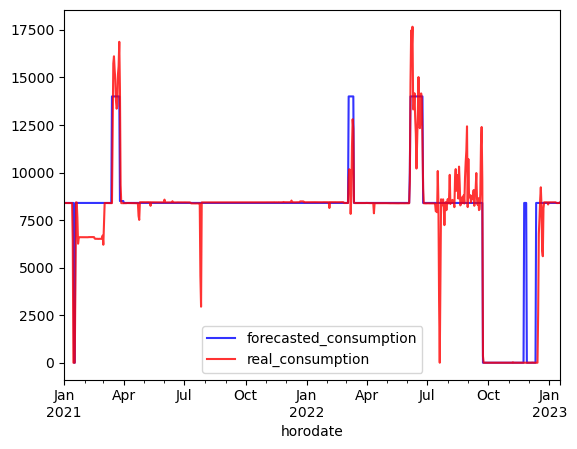

In [9]:
data.plot(x = "horodate", y = ["forecasted_consumption","real_consumption"], color = ["blue", "red"], alpha = 0.8)
plt.savefig(f"../../output/client{client}/forecasted_vs_real.jpg");

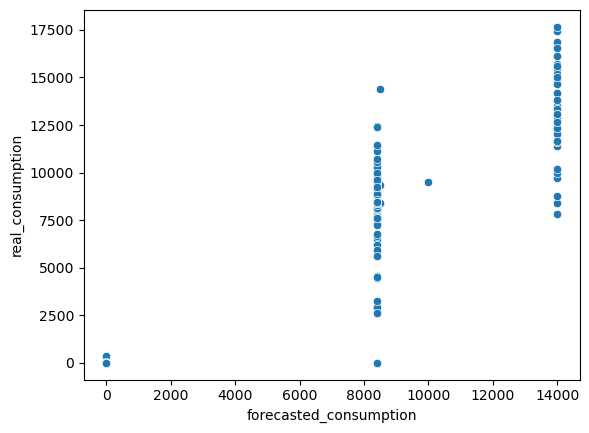

In [10]:
sns.scatterplot(x = "forecasted_consumption", y = "real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_forecasted_vs_real.jpg");

## Etude des corrélations

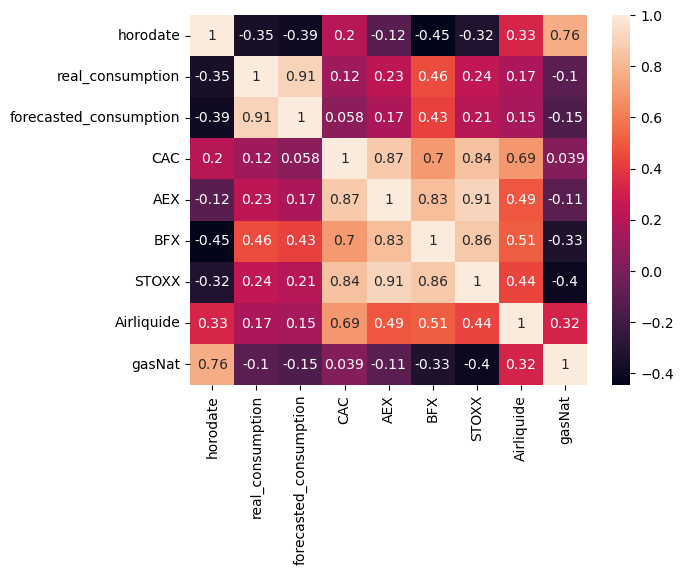

In [11]:
sns.heatmap(data.corr(), annot=True)
plt.savefig(f"../../output/client{client}/corr.png");

### CAC

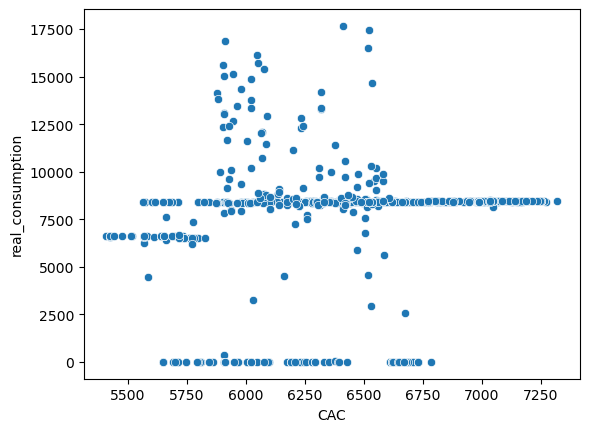

In [12]:
sns.scatterplot(x = "CAC", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_cac_real"); 

### BFX

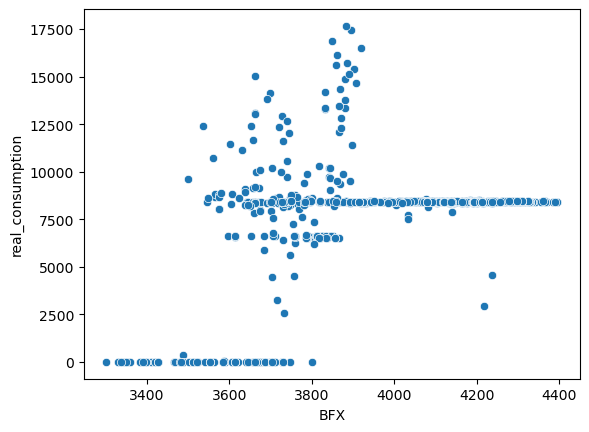

In [13]:
sns.scatterplot(x = "BFX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_bfx_real"); 

### AEX

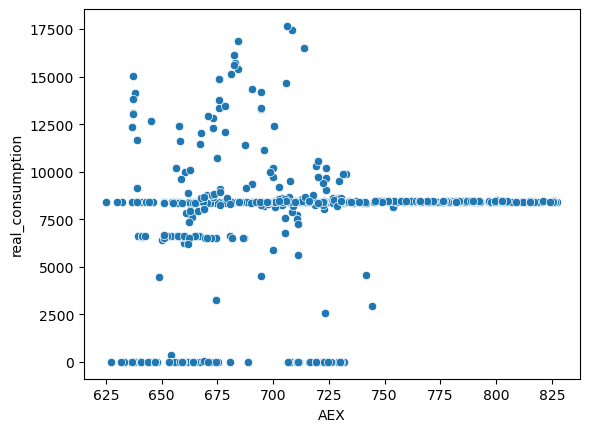

In [14]:
sns.scatterplot(x = "AEX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_aex_real"); 

### STOXX

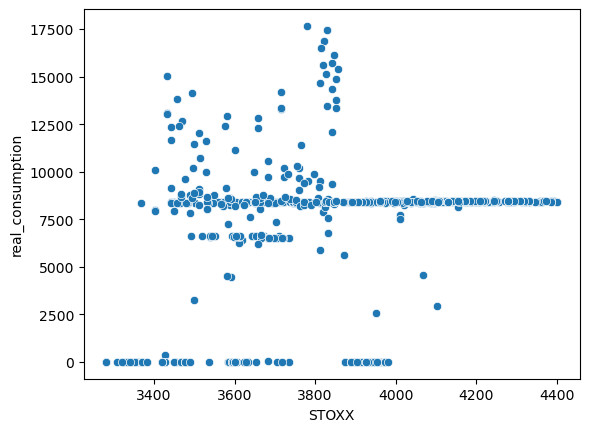

In [15]:
sns.scatterplot(x = "STOXX", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_stoxx_real"); 

### Gas naturel

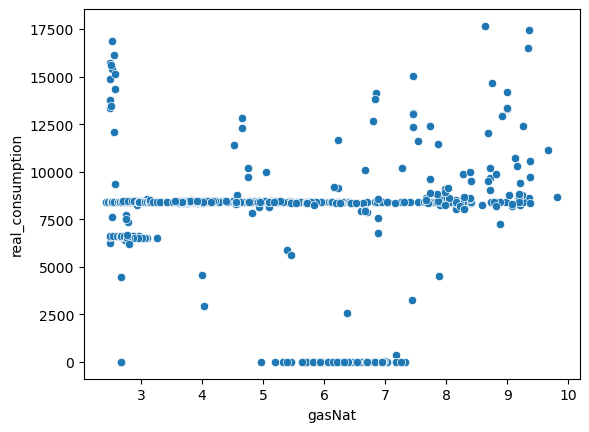

In [16]:
sns.scatterplot(x = "gasNat", y ="real_consumption", data = data)
plt.savefig(f"../../output/client{client}/scatter_gasNat_real"); 

# Application des modèles

## Modèle 1 : régression linéaire

### Avec une seule variable : forecasted_consumption

In [17]:
# découpage des sets de données
X = data[["forecasted_consumption"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [19]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

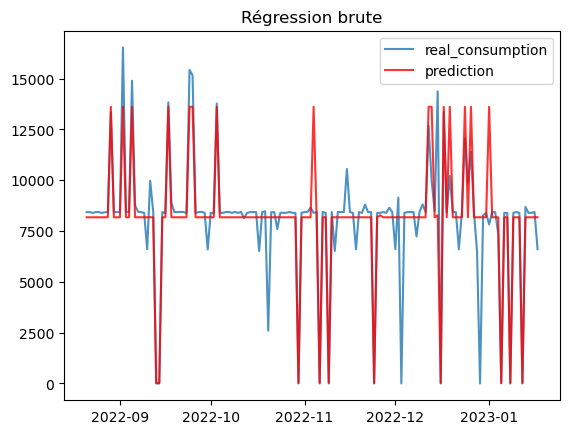

In [20]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression brute")
plt.legend()
plt.savefig(f"../../output/client{client}/simple_linear_regression.png");

#### Erreur de prédiction du client

In [21]:
# erreur entre la consommation réelle et celle prédite par le client
error = [mean_squared_error(y_test, X_test["forecasted_consumption"]), mean_absolute_error(y_test, X_test["forecasted_consumption"]), r2_score(y_test, X_test["forecasted_consumption"])]
error.append(np.NaN)
error

[2516514.2054913333, 616.1944666666666, 0.710020348452726, nan]

In [22]:
results = concat_results("erreur_prediction_client",error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2.516514e+06,616.194467,0.71002,NaN


#### Erreur du modèle 

In [23]:
# erreur sur l'entrainement
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [24]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.88064973, 0.81613473, 0.89113723, 0.84832611, 0.73964342])

In [25]:
results = concat_results("erreur_régression_simple", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2516514.205491,616.194467,0.71002,NaN
erreur_régression_simple,2383949.16918,736.221626,0.725296,"[0.881, 0.816, 0.891, 0.848, 0.74]"


In [26]:
# enregistrement du modèle
dump(model, f'../../output/client{client}/modèles/simple_linear_regression.joblib');

### Avec toutes les données boursières

In [27]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [29]:
# création du modèle
model = LinearRegression()
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

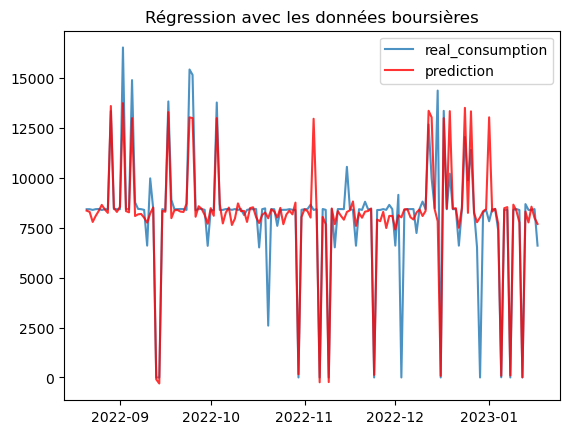

In [30]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Régression avec les données boursières")
plt.legend()
plt.savefig(f"../../output/client{client}/complet_linear_regression.png");

#### Erreur du modèle 

In [31]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error

[2219848.1970604183, 702.4989952501614, 0.7442053753295845]

In [32]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.88706563, 0.81344052, 0.89424509, 0.850079  , 0.74219463])

In [33]:
results = concat_results("erreur_régression_complète", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2516514.205491,616.194467,0.71002,NaN
erreur_régression_simple,2383949.16918,736.221626,0.725296,"[0.881, 0.816, 0.891, 0.848, 0.74]"
erreur_régression_complète,2219848.19706,702.498995,0.744205,"[0.887, 0.813, 0.894, 0.85, 0.742]"


In [34]:
# enregistrement du modèle
dump(model, f'../../output/client{client}/modèles/complet_linear_regression.joblib');

## Modèle 2 : Random Forest

In [35]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [37]:
# création du modèle
model = RandomForestRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

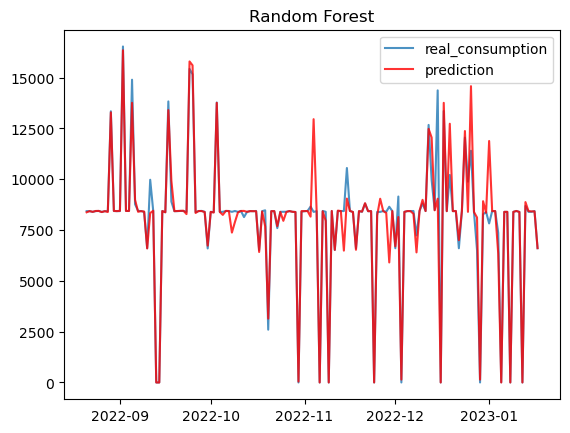

In [38]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Random Forest")
plt.legend()
plt.savefig(f"../../output/client{client}/random_forest.png");

#### Erreur du modèle

In [39]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [40]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.95249649, 0.95752228, 0.92882933, 0.93310845, 0.76746138])

In [41]:
results = concat_results("random_forest", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2516514.205491,616.194467,0.71002,NaN
erreur_régression_simple,2383949.16918,736.221626,0.725296,"[0.881, 0.816, 0.891, 0.848, 0.74]"
erreur_régression_complète,2219848.19706,702.498995,0.744205,"[0.887, 0.813, 0.894, 0.85, 0.742]"
random_forest,784663.596285,327.359837,0.909583,"[0.952, 0.958, 0.929, 0.933, 0.767]"


In [42]:
# enregistrement du modèle 
dump(model, f'../../output/client{client}/modèles/random_forest.joblib');

## Modèle 3 : Gradient Boosting

In [43]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [45]:
# création du modèle
model = GradientBoostingRegressor(n_estimators=200,random_state=42)
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

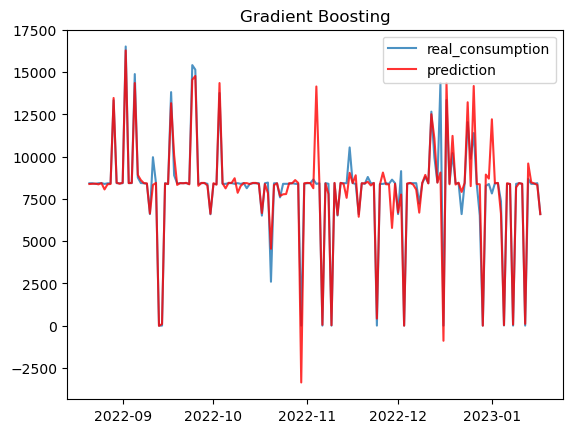

In [46]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("Gradient Boosting")
plt.legend()
plt.savefig(f"../../output/client{client}/gradient_boosting.png");

#### Erreurs du modèle

In [47]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [48]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.89900791, 0.91064108, 0.89526742, 0.87981857, 0.77436107])

In [49]:
results = concat_results("gradien_boosting", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2516514.205491,616.194467,0.71002,NaN
erreur_régression_simple,2383949.16918,736.221626,0.725296,"[0.881, 0.816, 0.891, 0.848, 0.74]"
erreur_régression_complète,2219848.19706,702.498995,0.744205,"[0.887, 0.813, 0.894, 0.85, 0.742]"
random_forest,784663.596285,327.359837,0.909583,"[0.952, 0.958, 0.929, 0.933, 0.767]"
gradien_boosting,949934.36954,408.181002,0.890538,"[0.899, 0.911, 0.895, 0.88, 0.774]"


In [50]:
# enristrement du modèle
dump(model, f"../../output/client{client}/modèles/gradient_boosting.joblib");

## Modèle 4 : Support vector machine

In [51]:
# découpage des sets de données
X = data[["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"]]
y = data["real_consumption"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
#on met les données à l'échelle
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [53]:
"""
# on règle la machine à vecteur de support 
param_grid = {
    'C': [100, 150, 200, 250],
    'kernel': ["poly"],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'coef0': [1.0, 2.0, 3.0]
}

# Créer le modèle Gradient Boosting
SVM = SVR()

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train_norm, y_train)
grid_search.best_estimator_
"""

'\n# on règle la machine à vecteur de support \nparam_grid = {\n    \'C\': [100, 150, 200, 250],\n    \'kernel\': ["poly"],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'degree\': [2, 3, 4],\n    \'coef0\': [1.0, 2.0, 3.0]\n}\n\n# Créer le modèle Gradient Boosting\nSVM = SVR()\n\n# Créer l\'objet GridSearchCV\ngrid_search = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\n# Effectuer la recherche sur grille sur les données d\'entraînement\ngrid_search.fit(X_train_norm, y_train)\ngrid_search.best_estimator_\n'

In [54]:
model = SVR(C=250, coef0=3.0, degree=4, kernel='poly')

In [55]:
model.fit(X_train_norm, y_train)
y_pred = model.predict(X_test_norm)

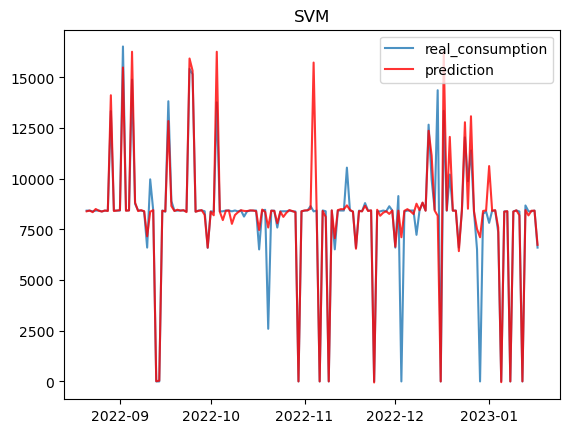

In [56]:
time = data["horodate"][-len(y_test):]
plt.plot(time,y_test, label = "real_consumption", alpha = 0.8)
plt.plot(time, y_pred, label = "prediction", color = 'red', alpha = 0.8)
plt.title("SVM")
plt.legend()
plt.savefig(f"../../output/client{client}/SVM.png");

#### Erreurs sur le modèle

In [57]:
error = [mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]
error

[1793805.7198473215, 462.0831438370212, 0.7932985411130338]

In [58]:
# validation croisée
scores = cross_val_score(model, X_train_norm, y_train, cv=5)
error.append(np.round(scores, decimals=3))
scores

array([0.91793821, 0.85623511, 0.92717377, 0.87097706, 0.76913866])

In [59]:
results = concat_results("SVM", error)
results

,MSE,MAE,R2,crossVal
erreur_prediction_client,2516514.205491,616.194467,0.71002,NaN
erreur_régression_simple,2383949.16918,736.221626,0.725296,"[0.881, 0.816, 0.891, 0.848, 0.74]"
erreur_régression_complète,2219848.19706,702.498995,0.744205,"[0.887, 0.813, 0.894, 0.85, 0.742]"
random_forest,784663.596285,327.359837,0.909583,"[0.952, 0.958, 0.929, 0.933, 0.767]"
gradien_boosting,949934.36954,408.181002,0.890538,"[0.899, 0.911, 0.895, 0.88, 0.774]"
SVM,1793805.719847,462.083144,0.793299,"[0.918, 0.856, 0.927, 0.871, 0.769]"


In [60]:
# enregistrement du modèle
dump(model, f"../../output/client{client}/modèles/SVM.joblib");

In [61]:
# enregistrement des résultats 
results.to_csv(f"../../output/client{client}/results.csv")